In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import cv2
from skimage import color
import os

2025-04-22 10:36:33.143529: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 10:36:33.146779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 10:36:33.155364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745310993.170267   24078 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745310993.174612   24078 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745310993.186679   24078 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Ogólny wgląd na dane

In [2]:
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784', version=1)

In [3]:
mnist_data['data']

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Liczba jest równa 0
Jej reprezentacja jako obrazu to AxesImage(shape=(28, 28))


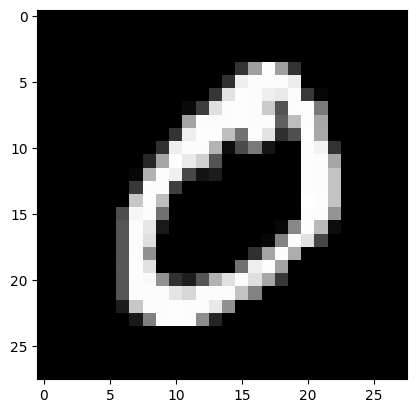

In [4]:
print('Liczba jest równa {}'.format(mnist_data['target'][1]))
print('Jej reprezentacja jako obrazu to {}'.format(plt.imshow(mnist_data['data'].values[1].reshape(28,28),cmap='gray')))

### Budowanie modelu 

In [5]:
model = keras.Sequential()
model.add(keras.layers.Dense(256, activation = 'relu',input_shape = (28*28, )))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))
model.compile('adam',loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

/home/jakub-mieszczak/Desktop/old_git/Number-Detector/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-22 10:36:38.987507: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [6]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,274 (1012.79 KB)

 Trainable params: 259,274 (1012.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
X = [mnist_data['data'].values[x].reshape(784,) for x in range(mnist_data['data'].shape[0])]
y = mnist_data['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41, test_size = 0.1)
X_train, X_test = np.array(X_train), np.array(X_test)

In [8]:
r = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2025-04-22 10:36:49.682666: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 395136000 exceeds 10% of free system memory.


1969/1969 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8195 - loss: 2.0047 - val_accuracy: 0.9330 - val_loss: 0.2374
Epoch 2/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9436 - loss: 0.1980 - val_accuracy: 0.9419 - val_loss: 0.2181
Epoch 3/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9563 - loss: 0.1495 - val_accuracy: 0.9566 - val_loss: 0.1536
Epoch 4/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9667 - loss: 0.1168 - val_accuracy: 0.9550 - val_loss: 0.1780
Epoch 5/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9703 - loss: 0.1037 - val_accuracy: 0.9631 - val_loss: 0.1351
Epoch 6/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9763 - loss: 0.0831 - val_accuracy: 0.9710 - val_loss: 0.1168
Epoch 7/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9786 - loss: 0.0760 - val_accuracy: 0.9689 - val_loss: 0.1245
Epoch 8/20
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9828 - loss: 0.0627 - val_accurac

In [32]:
from open_atmos_jupyter_utils import show_plot, show_anim
from matplotlib import pyplot

acc = r.history['accuracy']
acc_val = r.history['val_accuracy']
loss = r.history['loss']
loss_val = r.history['val_loss']

def plot_acc(step):
    fig = pyplot.figure()
    pyplot.plot(list(range(step+1)), acc[:step+1]) 
    pyplot.plot(list(range(step+1)), acc_val[:step+1]) 
    pyplot.xlim(-1, step+1) 
    plt.title("Model train and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend(["Accuracy", "Val Accuracy"], loc ="lower right")
    plt.grid()
    return fig 

def plot_loss(step):
    fig = pyplot.figure()
    pyplot.plot(list(range(step+1)), loss[:step+1]) 
    pyplot.plot(list(range(step+1)), loss_val[:step+1]) 
    pyplot.xlim(-1, step+1) 
    plt.title("Model train and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Val Loss"], loc ="upper right")
    plt.grid()
    return fig 

<Figure size 640x480 with 0 Axes>


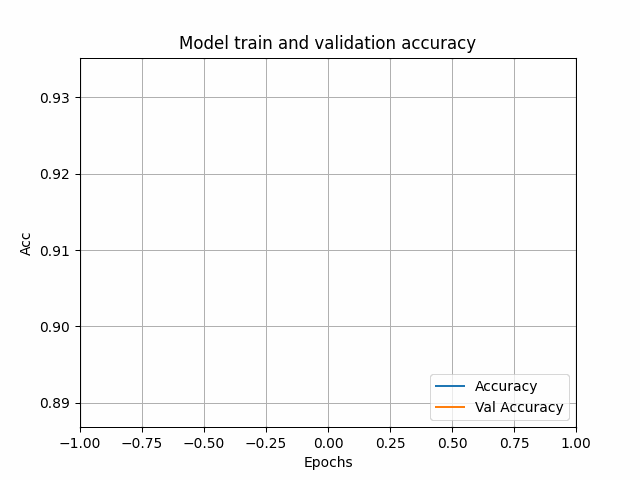

HTML(value="<a href='./tmp50wlmavl.gif' target='_blank'>./tmp50wlmavl.gif</a><br>")

In [33]:
show_plot('numeric.pdf')
show_anim(plot_acc, range(0, 20, 1))

<Figure size 640x480 with 0 Axes>


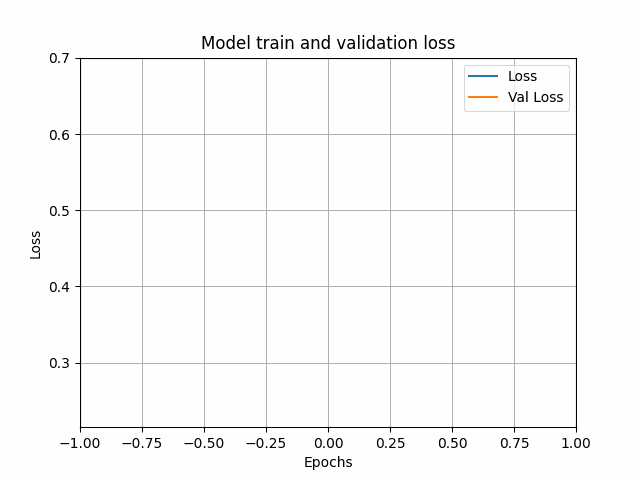

HTML(value="<a href='./tmpakthgjb3.gif' target='_blank'>./tmpakthgjb3.gif</a><br>")

In [34]:
show_plot('numeric.pdf')
show_anim(plot_loss, range(0, 20, 1))

###  Sprawdzanie skuteczności modelu na niewidzianych danych

In [29]:
y_pred=model.predict(X_test)
y_pred=np.array([np.where(elem==elem.max())[0][0] for elem in y_pred])
y_test=np.array(y_test)

def score(y_test,y_pred):
    wynik=0
    cal=len(y_test)
    for id, _ in enumerate(y_pred):
        if y_pred[id]==y_test[id]:
            wynik=wynik+1
    return (wynik/cal)*100
print('Skuteczność modelu na danych testowych: {}%'.format(score(y_test, y_pred)))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
Skuteczność modelu na danych testowych: 97.65714285714286%


In [25]:
model.predict(X_test)[850].max()

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


np.float32(0.99999994)

### Zapisywanie modelu

In [23]:
model.save('model.h5')
my_model=load_model('model.h5')

2


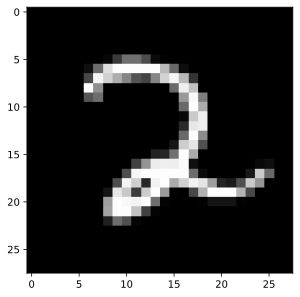

In [22]:
print(y_test[22])
plt.imshow(X_test[22].reshape(28,28), cmap='gray')